In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/pima-indians-diabetes-database/diabetes.csv


### Importing Prima Dataset & Setting Up File Path

In [2]:
data = pd.read_csv('../input/pima-indians-diabetes-database/diabetes.csv')
display(data.info(),data.head())
print("Number Of Rows & Collumns : ",data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Number Of Rows & Collumns :  (768, 9)


### Understanding The Dataset 

In [3]:
# 2 datasets
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]


def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)


def target_percent():
    trace = go.Pie(labels = ['Healthy','Diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')
target_count()
target_percent()

### Checking For Missing Values In The Dataset 

In [4]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Here we can see few values of data with 0, for example Insulin levels, or SkinThickness these need to be handled appropriately 

#### Intially replace the redundant values with NaN 

In [5]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

#### Visualization Of The Missing Data

In [6]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
missing_plot(data, 'Outcome')

#### Attribute Distributions 

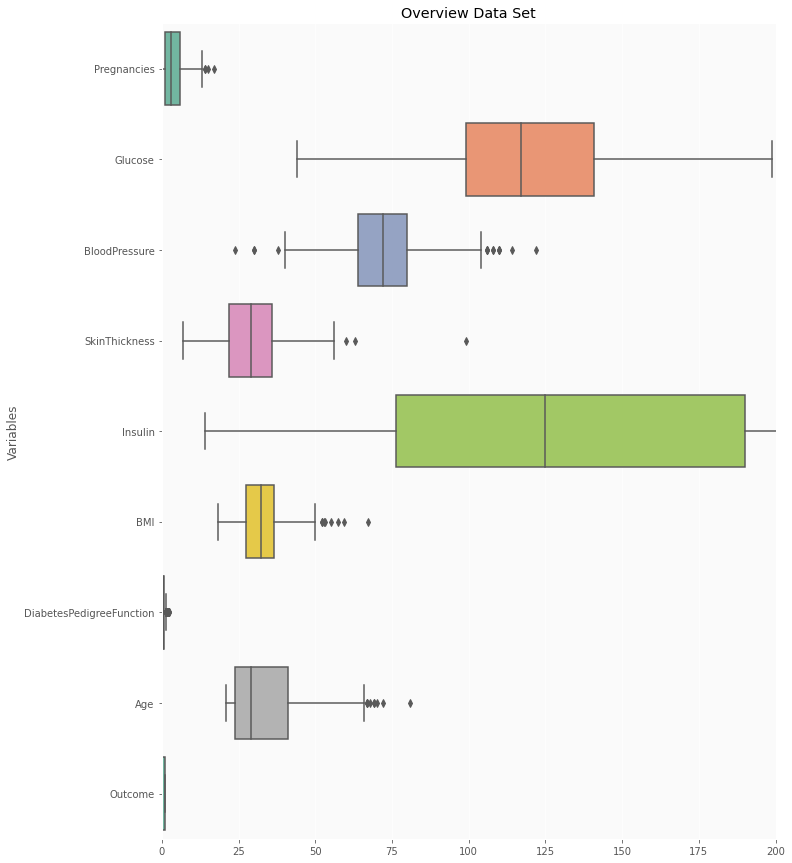

In [7]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

### Understanding The Correlations  

In [8]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            autosize = True,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 6)),
                            xaxis   = dict(tickfont = dict(size = 6)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)
correlation_plot()


#### Data Pre-Processing - Updating NaN Values With Global Median 

In [9]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [10]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [11]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

In [12]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [13]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [14]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [15]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [16]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [17]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [18]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [19]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [20]:
missing_plot(data, 'Outcome')

In [21]:
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)
plot_distribution('BMI', 0)

#### Standardising The Dataset & LabelEncoding

In [22]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [23]:
correlation_plot()

### Performing Predictions 

In [24]:
# Def X and Y
X = data.drop('Outcome', 1)
Y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



### Naive Bayes

In [25]:
model = GaussianNB()
cv_scores = cross_val_score(model, X, Y, cv=5)
    
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GaussianNB()  mean accuracy:  77.09 % std:  0.081 %


In [26]:
y_pred = model.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 231 points : 53


In [27]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.7690875232774674
accuracy_score on test dataset :  0.7705627705627706


              precision    recall  f1-score   support

           0       0.81      0.83      0.82       343
           1       0.69      0.65      0.67       194

    accuracy                           0.77       537
   macro avg       0.75      0.74      0.75       537
weighted avg       0.77      0.77      0.77       537

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       157
           1       0.68      0.54      0.60        74

    accuracy                           0.77       231
   macro avg       0.74      0.71      0.72       231
weighted avg       0.76      0.77      0.76       231



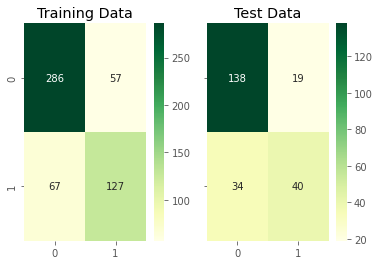

In [28]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

print(classification_report(y_train,predict_train))
print(classification_report(y_test,predict_test))

### Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
model=GradientBoostingClassifier(n_estimators=400,learning_rate=0.1,random_state=100,max_features=4 )
cv_scores = cross_val_score(model, X, Y, cv=5)
    
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=100)  mean accuracy:  88.938 % std:  0.051 %


In [30]:
y_pred = model.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 231 points : 23


In [31]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  1.0
accuracy_score on test dataset :  0.9004329004329005


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       343
           1       1.00      1.00      1.00       194

    accuracy                           1.00       537
   macro avg       1.00      1.00      1.00       537
weighted avg       1.00      1.00      1.00       537

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       157
           1       0.86      0.82      0.84        74

    accuracy                           0.90       231
   macro avg       0.89      0.88      0.88       231
weighted avg       0.90      0.90      0.90       231



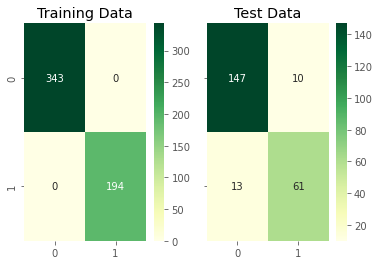

In [32]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

print(classification_report(y_train,predict_train))
print(classification_report(y_test,predict_test))

### Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(penalty='l2', C=0.3,class_weight = "balanced")
cv_scores = cross_val_score(model, X, Y, cv=5)
print(model, ' mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(cv_scores.var()*100, 3),'%')

LogisticRegression(C=0.3, class_weight='balanced')  mean accuracy:  79.431 % std:  0.038 %


In [34]:
y_pred = model.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 231 points : 50


In [35]:
predict_train = model.fit(X_train, y_train).predict(X_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = model.predict(X_test)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.7895716945996276
accuracy_score on test dataset :  0.7835497835497836


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       343
           1       0.69      0.77      0.73       194

    accuracy                           0.79       537
   macro avg       0.77      0.78      0.78       537
weighted avg       0.80      0.79      0.79       537

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       157
           1       0.66      0.68      0.67        74

    accuracy                           0.78       231
   macro avg       0.75      0.76      0.75       231
weighted avg       0.79      0.78      0.78       231



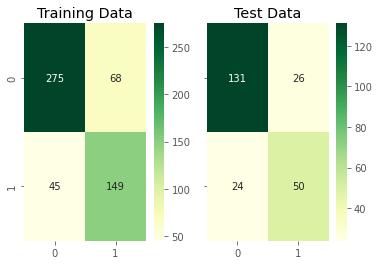

In [36]:
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

print(classification_report(y_train,predict_train))
print(classification_report(y_test,predict_test))